### 1. การตั้งค่าและนำเข้าข้อมูล (Setup and Data Import)
ในส่วนนี้ เราจะติดตั้ง kagglehub นำเข้าไลบรารีที่จำเป็น และดาวน์โหลดชุดข้อมูลจาก Kaggle

In [ ]:
# ------------------------------------------------------------------
# Section 1 (FIXED v6 - Loading CSVs)
# ------------------------------------------------------------------

# 1. ติดตั้ง Kaggle
!pip install kaggle

# 2. นำเข้าไลบรารีที่จำเป็น
import os
import pandas as pd # <--- นำเข้า pandas
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split # <--- นำเข้า train_test_split

# 3. ดึง Secrets ที่เราเก็บไว้
from google.colab import userdata
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')
print("Kaggle API configured.")

# 4. ดาวน์โหลดชุดข้อมูล
print("Downloading dataset...")
!kaggle datasets download -d phucthaiv02/butterfly-image-classification

# 5. แตกไฟล์ (Unzip) - แก้ไขให้บังคับแตกไฟล์ทับ (overwrite)
print("Unzipping dataset...")
!unzip -oq butterfly-image-classification.zip -d /content/ # -o = overwrite, -q = quiet
print("Dataset unzipped.")

# 6. ตั้งค่า Path ใหม่ทั้งหมด
train_dir = '/content/train'
test_dir = '/content/test'
train_csv_path = '/content/Training_set.csv'
test_csv_path = '/content/Testing_set.csv'

# 7. ตรวจสอบ Path
print("\n--- Checking Data Paths ---")
print(f"Train directory exists: {os.path.exists(train_dir)}")
print(f"Test directory exists: {os.path.exists(test_dir)}")
print(f"Train CSV exists: {os.path.exists(train_csv_path)}")
print(f"Test CSV exists: {os.path.exists(test_csv_path)}")

Kaggle API configured.
Dataset URL: https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification
License(s): CC0-1.0
butterfly-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
Unzipping dataset...
Dataset unzipped.

--- Checking Data Paths ---
Train directory exists: True
Test directory exists: True
Train CSV exists: True
Test CSV exists: True


### 2. การสำรวจและเตรียมข้อมูล (Data Exploration and Preprocessing)

Total images in Main CSV: 6499

--- Main Data Head (ตัวอย่างข้อมูล) ---
      filename                     label
0  Image_1.jpg          SOUTHERN DOGFACE
1  Image_2.jpg                    ADONIS
2  Image_3.jpg            BROWN SIPROETA
3  Image_4.jpg                   MONARCH
4  Image_5.jpg  GREEN CELLED CATTLEHEART

Found 75 classes.

Training samples:   5199
Validation samples: 650
Test samples:       650

Data preparation complete (GPU Saving Version: 160x160, Batch 16).


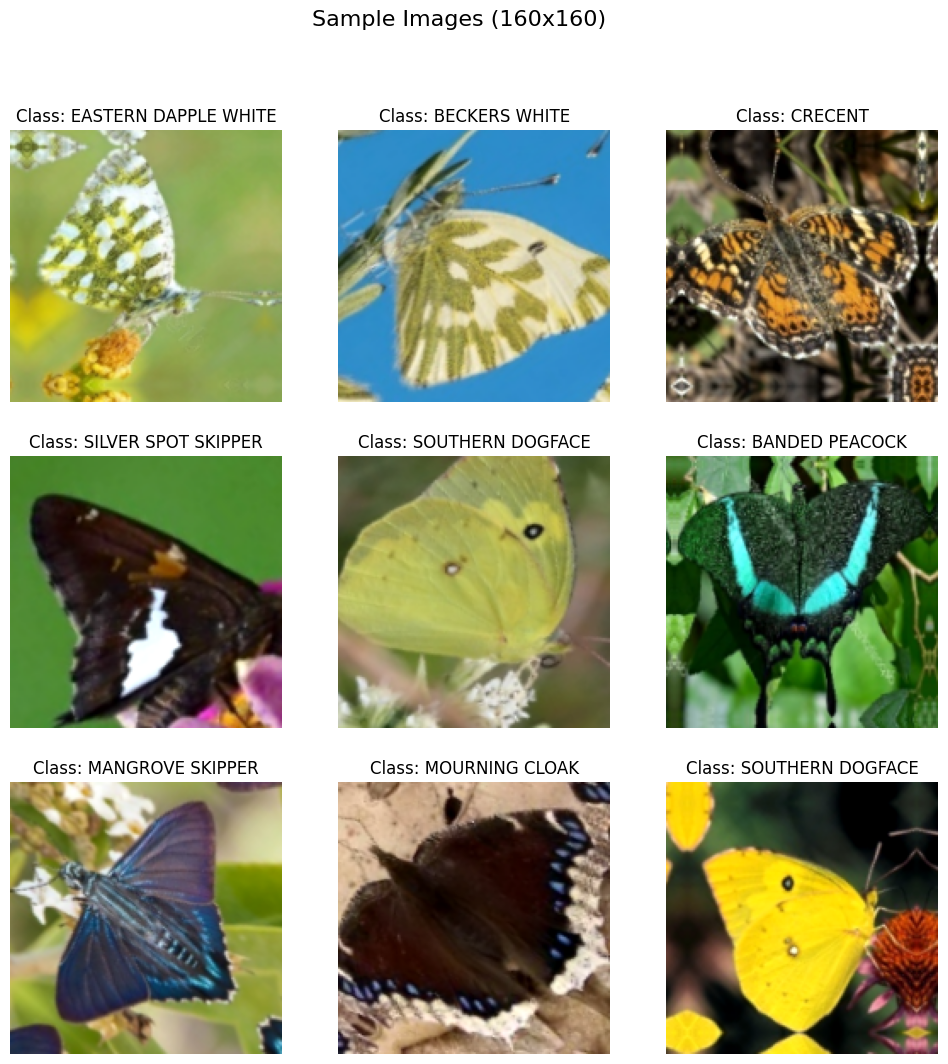

In [ ]:
# ------------------------------------------------------------------
# Section 2 (FIXED v3 - GPU Saving Version)
# (ปรับลด IMG_SIZE และ BATCH_SIZE)
# ------------------------------------------------------------------

# --- ตั้งค่าตัวแปรพื้นฐาน ---
IMG_SIZE = (160, 160)  # <-- ลดขนาดจาก (224, 224)
BATCH_SIZE = 16        # <-- ลดขนาดจาก 32

# --- 1. โหลดข้อมูล CSV ด้วย Pandas ---
try:
    main_df = pd.read_csv(train_csv_path)
except Exception as e:
    print(f"Error reading CSV: {e}")

print(f"Total images in Main CSV: {len(main_df)}")
print("\n--- Main Data Head (ตัวอย่างข้อมูล) ---")
print(main_df.head())

# --- 2. เตรียมข้อมูล (เพิ่ม Path และแปลง Label) ---
main_df['filepath'] = train_dir + '/' + main_df['filename']
class_names = sorted(main_df['label'].unique())
num_classes = len(class_names)
print(f"\nFound {num_classes} classes.")

class_to_int = {label: i for i, label in enumerate(class_names)}
int_to_class = {i: label for i, label in enumerate(class_names)}
main_df['label_int'] = main_df['label'].map(class_to_int)

# --- 3. แบ่งข้อมูลเป็น Train (80%), Validation (10%), Test (10%) ---
from sklearn.model_selection import train_test_split # ตรวจสอบว่า import แล้ว

train_df, temp_df = train_test_split(
    main_df, test_size=0.2, random_state=42, stratify=main_df['label']
)
valid_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df['label']
)

print(f"\nTraining samples:   {len(train_df)}")
print(f"Validation samples: {len(valid_df)}")
print(f"Test samples:       {len(test_df)}")

# --- 4. สร้างฟังก์ชันโหลดรูปภาพ ---
def load_and_preprocess_image(filepath, label):
    img = tf.io.read_file(filepath)
    img = tf.io.decode_jpeg(img, channels=3)
    # ใช้ IMG_SIZE ใหม่ที่นี่
    img = tf.image.resize(img, [IMG_SIZE[0], IMG_SIZE[1]])
    return img, label

# --- 5. สร้าง tf.data.Dataset ---
AUTOTUNE = tf.data.AUTOTUNE

# สร้าง Train Dataset
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df['filepath'].values, train_df['label_int'].values)
)
train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=len(train_df))
train_ds = train_ds.batch(BATCH_SIZE) # <--- ใช้ BATCH_SIZE ใหม่

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),  # เพิ่มการหมุน
    layers.RandomZoom(0.2),     # เพิ่มการซูม
    layers.RandomContrast(0.2), # เพิ่มการปรับ Contrast
])
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

# สร้าง Validation Dataset
valid_ds = tf.data.Dataset.from_tensor_slices(
    (valid_df['filepath'].values, valid_df['label_int'].values)
)
valid_ds = valid_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
valid_ds = valid_ds.batch(BATCH_SIZE) # <--- ใช้ BATCH_SIZE ใหม่
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)

# สร้าง Test Dataset
test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df['filepath'].values, test_df['label_int'].values)
)
test_ds = test_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE) # <--- ใช้ BATCH_SIZE ใหม่
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

print("\nData preparation complete (GPU Saving Version: 160x160, Batch 16).")

# --- 6. แสดงผล Input Data (เพื่อยืนยัน) ---
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(min(9, BATCH_SIZE)): # แสดงผลไม่เกิน 9 ภาพ
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Class: {int_to_class[labels[i].numpy()]}")
        plt.axis("off")
plt.suptitle("Sample Images (160x160)", fontsize=16)
plt.show()

### 3. การสร้างโมเดล (Building the Model)

In [ ]:
# ------------------------------------------------------------------
# Section 3: Building the Model (Transfer Learning)
# ------------------------------------------------------------------

# --- 1. โหลด Pre-trained Model (Base Model) ---
# เราจะใช้ MobileNetV2 ซึ่งเป็นโมเดลที่เบาและมีประสิทธิภาพสูง
# include_top=False หมายความว่าเราจะไม่เอาชั้น Classifier (ชั้นบนสุด) ของมันมา
# เราจะสร้างส่วนนั้นเอง
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),  # (224, 224, 3)
    include_top=False,
    weights='imagenet'          # ใช้น้ำหนัก (weights) ที่เรียนรู้จาก ImageNet
)

# "แช่แข็ง" (Freeze) Base Model เพื่อไม่ให้มันอัปเดต weights ในตอนเริ่มฝึก
# เราจะฝึกเฉพาะส่วนหัว (Head) ที่เราสร้างขึ้นใหม่ก่อน
base_model.trainable = False

# --- 2. สร้างโมเดลของเรา (Custom Model) ---
num_classes = len(class_names)

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))

# Rescaling Layer: ปรับค่าสีจาก [0, 255] -> [-1, 1] ตามที่ MobileNetV2 ต้องการ
# (วิธีนี้ดีกว่าการใช้ `Rescaling(1./127.5, offset=-1)` เพราะมันใช้ preprocess_input โดยตรง)
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)

# ส่งข้อมูลเข้า Base Model
x = base_model(x, training=False)  # ระบุ training=False เพราะเรา freeze ไว้

# สร้างส่วนหัว (Classifier Head) ของเราเอง
x = layers.GlobalAveragePooling2D()(x)  # ลดมิติข้อมูล
x = layers.Dropout(0.4)(x)              # ป้องกัน Overfitting
outputs = layers.Dense(num_classes, activation='softmax')(x) # ชั้น Output

# รวมร่างเป็นโมเดล
model = tf.keras.Model(inputs, outputs)

# --- 3. Compile โมเดล ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy', # เหมาะสำหรับ label ที่เป็นตัวเลข
    metrics=['accuracy']
)

# ดูสรุปโครงสร้างโมเดล
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 75)             │        96,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,354,059 (8.98 MB)

 Trainable params: 96,075 (375.29 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### 4. การฝึกสอนโมเดล (Model Training)

In [ ]:
# ------------------------------------------------------------------
# Section 4: Model Training
# ------------------------------------------------------------------

# --- Phase 1: Feature Extraction ---
print("\n--- Starting Initial Training (Feature Extraction) ---")
initial_epochs = 10

history = model.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=valid_ds
)

# --- Phase 2: Fine-Tuning ---
# "ละลาย" Base Model
base_model.trainable = True

# เราจะ Freeze เฉพาะบางชั้นล่างๆ และ Fine-tune เฉพาะชั้นบนๆ
# ยิ่งชั้นบน (ตัวเลขมาก) ยิ่งเรียนรู้ feature ที่เฉพาะเจาะจง
fine_tune_at = 100  # เริ่ม Fine-tune ตั้งแต่ชั้นที่ 100 ขึ้นไป

# Freeze ทุกชั้นก่อนชั้นที่ fine_tune_at
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile ใหม่อีกครั้งด้วย Learning Rate ที่ต่ำมากๆ
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5), # 0.00001
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\n--- Starting Fine-Tuning ---")
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1], # เริ่มนับ epoch ต่อจากของเดิม
    validation_data=valid_ds
)


--- Starting Initial Training (Feature Extraction) ---
Epoch 1/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 63s 119ms/step - accuracy: 0.2590 - loss: 3.3384 - val_accuracy: 0.7431 - val_loss: 1.1148
Epoch 2/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 32s 87ms/step - accuracy: 0.7204 - loss: 1.0715 - val_accuracy: 0.7969 - val_loss: 0.8176
Epoch 3/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 31s 82ms/step - accuracy: 0.7888 - loss: 0.7655 - val_accuracy: 0.8138 - val_loss: 0.6814
Epoch 4/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.8363 - loss: 0.6147 - val_accuracy: 0.8385 - val_loss: 0.6358
Epoch 5/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 40s 82ms/step - accuracy: 0.8401 - loss: 0.5351 - val_accuracy: 0.8400 - val_loss: 0.6008
Epoch 6/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.8560 - loss: 0.4944 - val_accuracy: 0.8492 - val_loss: 0.5479
Epoch 7/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 31s 81ms/step - accuracy: 0.8639 - loss: 0.4659 - val_accuracy: 0.8585 - val_loss: 0.5512
Epoch 8/10
325/325 ━━━━━━━━━━━━━━

### 5. การประเมินผลลัพธ์ (Evaluating the Results)

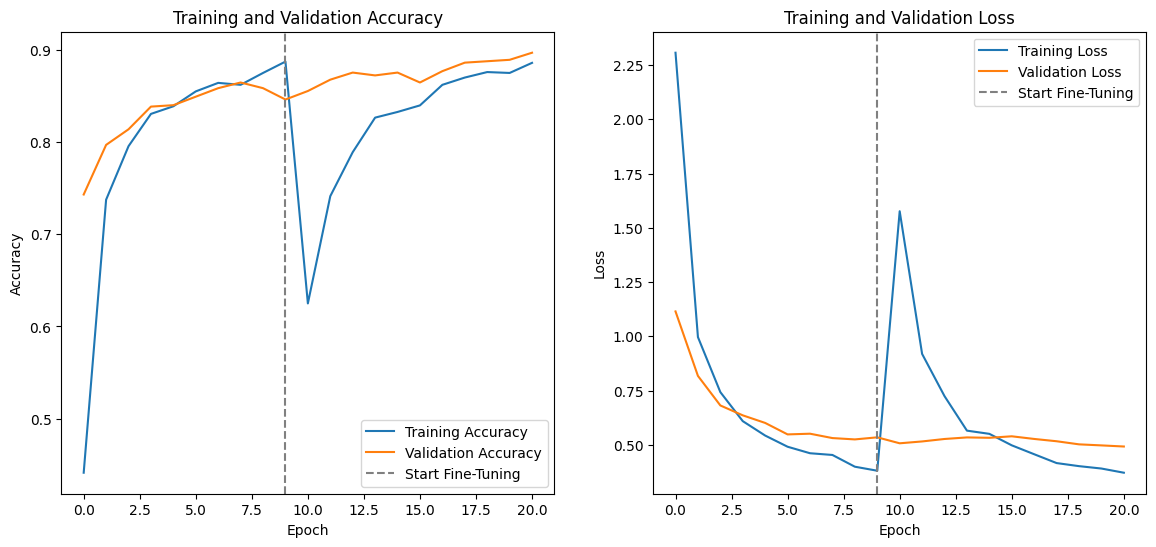


--- Evaluating on Test Set ---
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8975 - loss: 0.3743

Test Loss: 0.4043
Test Accuracy (เปอร์เซ็นความถูกต้อง): 89.08 %


In [ ]:
# ------------------------------------------------------------------
# Section 5: Evaluating the Results
# ------------------------------------------------------------------

# --- 1. แสดงผล Model Accuracy และ Model Loss (แบบกราฟ) ---

# รวมประวัติการฝึกทั้ง 2 phase
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(14, 6))

# กราฟ Model Accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(initial_epochs - 1, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# กราฟ Model Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(initial_epochs - 1, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

# --- 2. ประเมินโมเดลด้วย Test Set (เปอร์เซ็นความถูกต้อง) ---
print("\n--- Evaluating on Test Set ---")
test_loss, test_accuracy = model.evaluate(test_ds)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy (เปอร์เซ็นความถูกต้อง): {test_accuracy * 100:.2f} %")

### 6. การวิเคราะห์ผลลัพธ์เชิงลึก (Detailed Analysis)

Data for analysis collected.

--- Sample Prediction Results ---


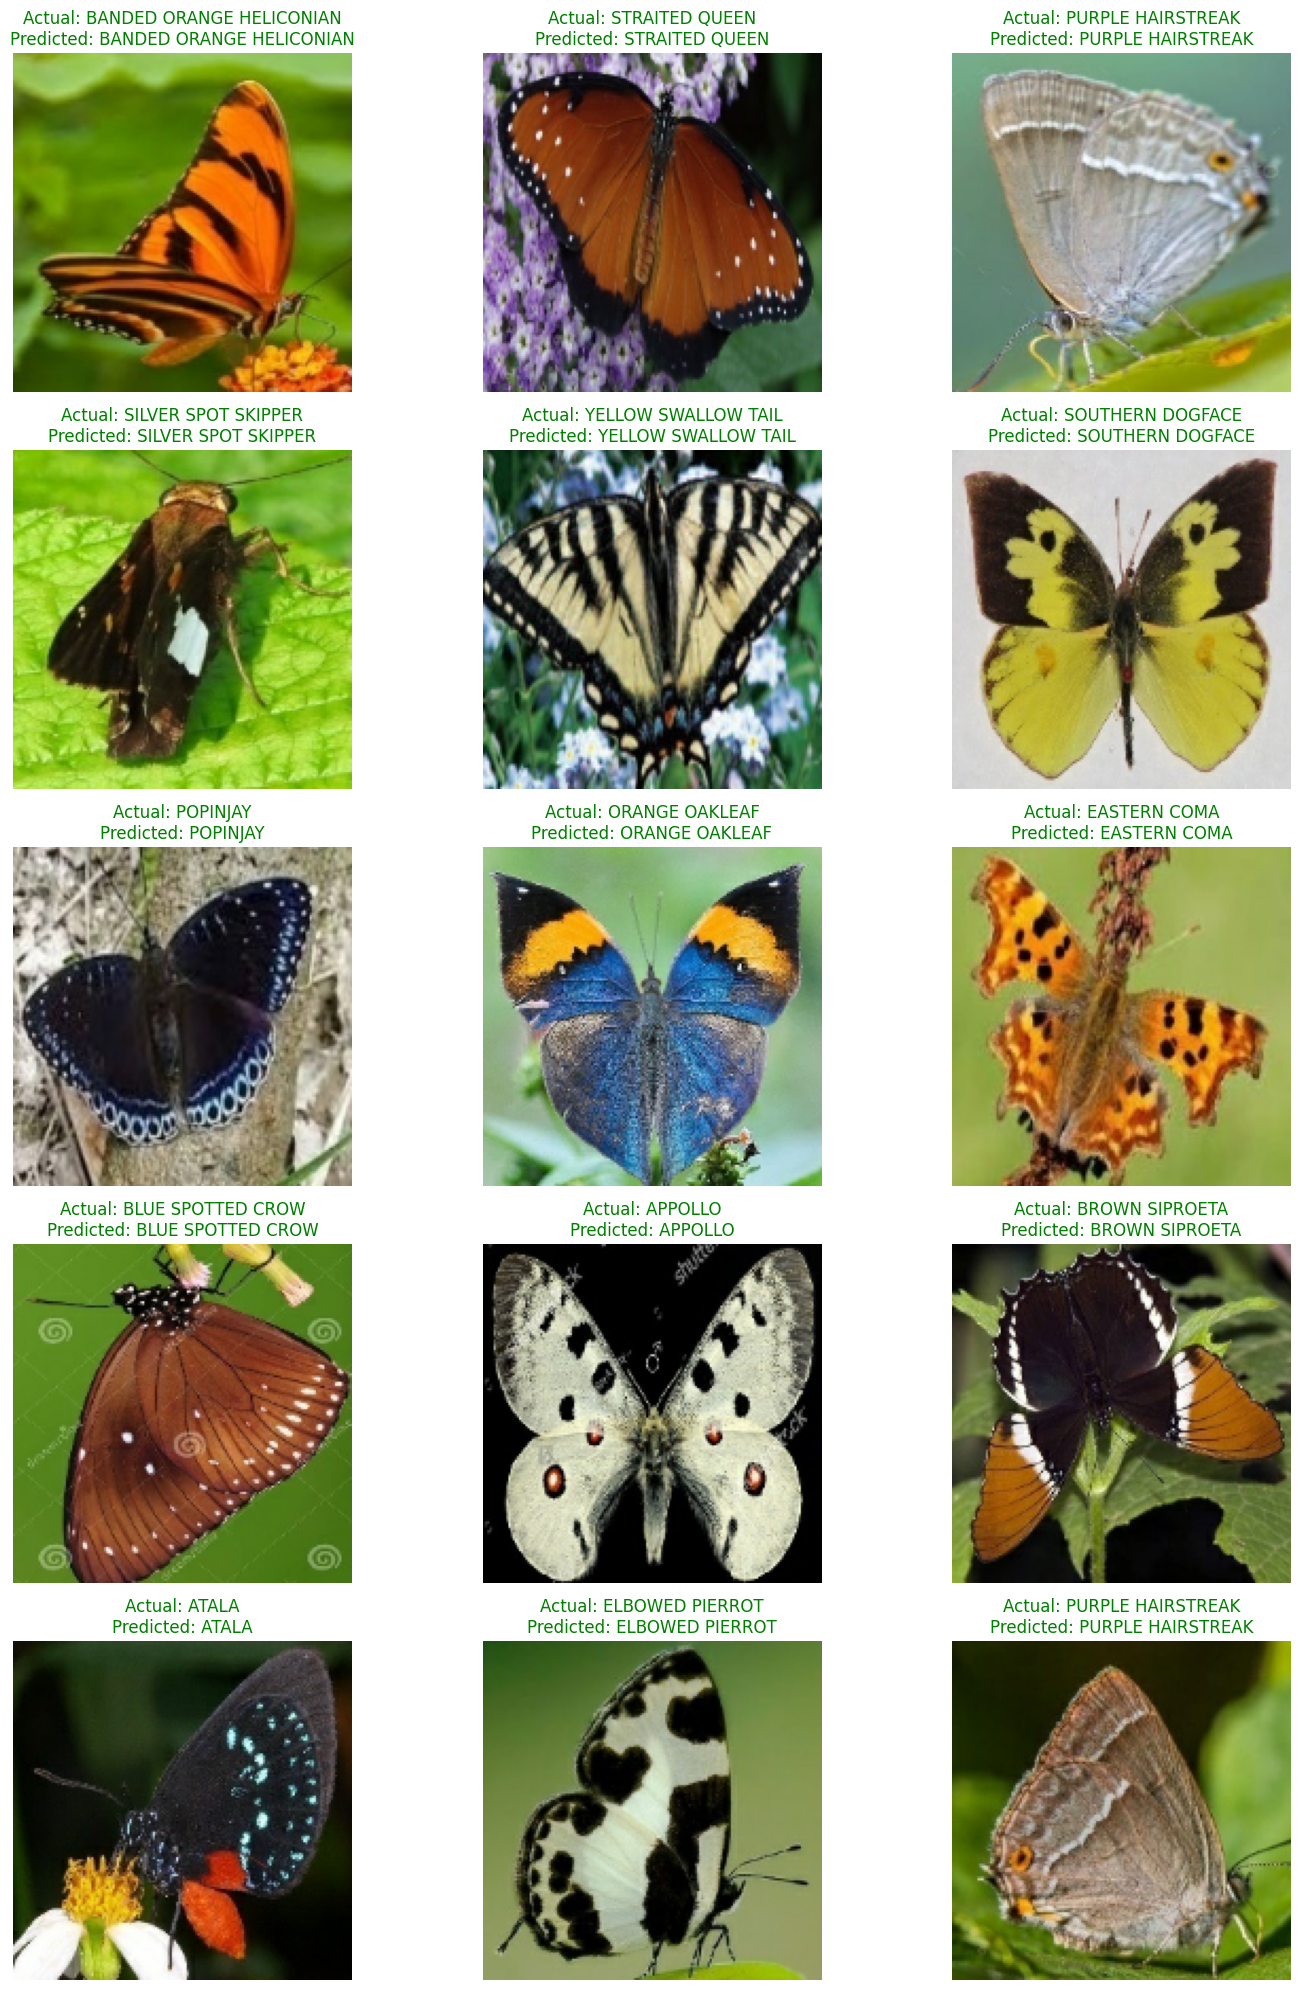


--- Confusion Matrix ---


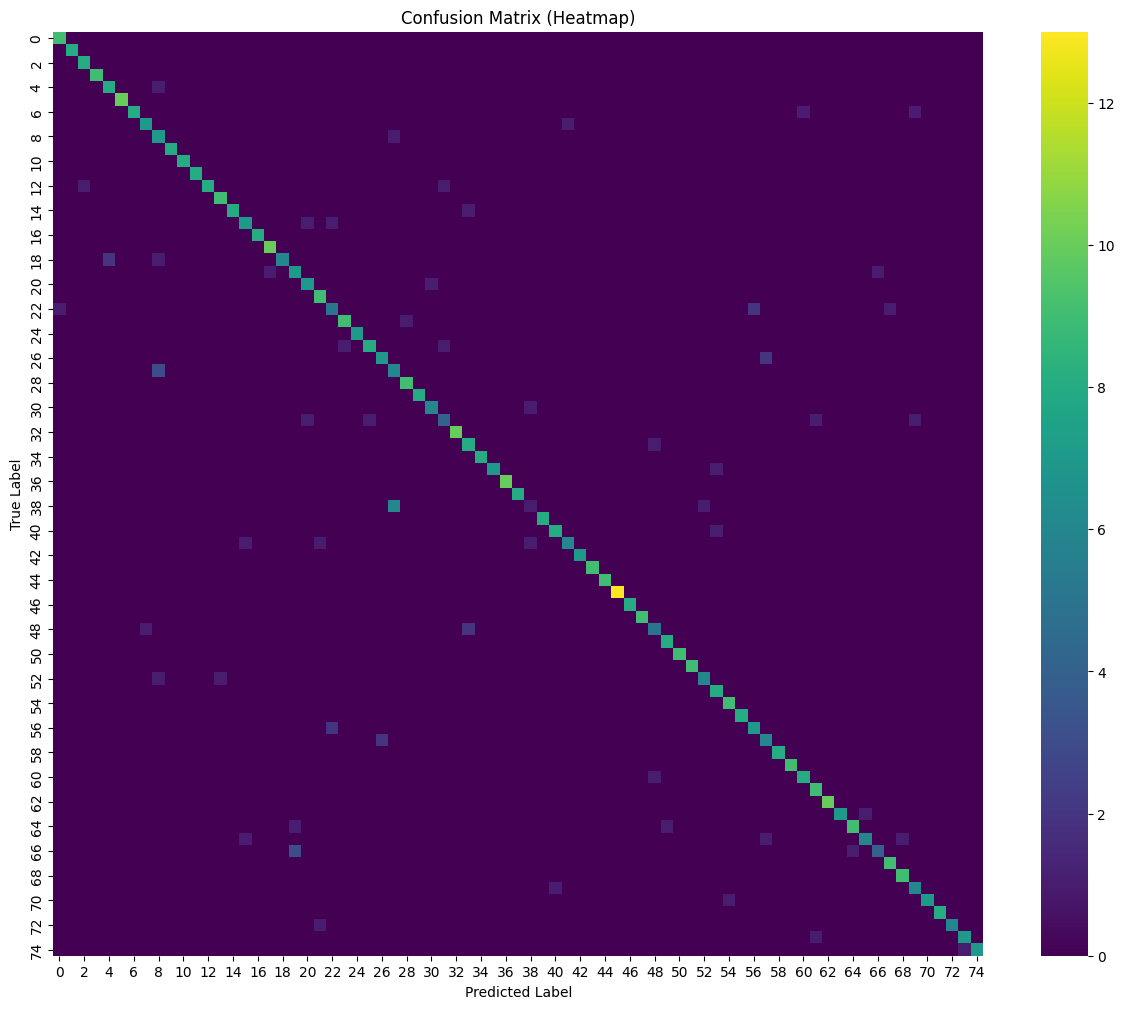


--- Classification Report ---
Overall Averages:
  Accuracy:  0.8908
  Macro Avg Precision: 0.8933
  Macro Avg Recall:    0.8896
  Macro Avg F1-Score:  0.8868

Top 20 Class Details:

Class: ADONIS
  Precision: 0.9000
  Recall:    1.0000
  F1-Score:  0.9474
  Support:   9.0

Class: AFRICAN GIANT SWALLOWTAIL
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000
  Support:   8.0

Class: AMERICAN SNOOT
  Precision: 0.8889
  Recall:    1.0000
  F1-Score:  0.9412
  Support:   8.0

Class: AN 88
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000
  Support:   9.0

Class: APPOLLO
  Precision: 0.8000
  Recall:    0.8889
  F1-Score:  0.8421
  Support:   9.0

Class: ATALA
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000
  Support:   10.0

Class: BANDED ORANGE HELICONIAN
  Precision: 1.0000
  Recall:    0.8000
  F1-Score:  0.8889
  Support:   10.0

Class: BANDED PEACOCK
  Precision: 0.8750
  Recall:    0.8750
  F1-Score:  0.8750
  Support:   8.0

Class: BECKERS WHITE
  Prec

In [ ]:
# ------------------------------------------------------------------
# Section 6: Detailed Analysis
# ------------------------------------------------------------------

# --- 1. ดึงข้อมูลจริง (y_true) และข้อมูลทำนาย (y_pred) จาก Test Set ---
# เราต้องวน loop เพื่อดึงข้อมูลทั้งหมดออกมาจาก (tf.data.Dataset)
y_pred = []
y_true = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))

print("Data for analysis collected.")

# --- 2. แสดงผลลัพธ์การทำนาย (Prediction Results) ---
print("\n--- Sample Prediction Results ---")
plt.figure(figsize=(15, 20))
# ดึง 1 batch จาก test_ds มาแสดงผล
for images, labels in test_ds.take(1):
    predictions = model.predict(images, verbose=0)
    predictions_idx = np.argmax(predictions, axis=1)

    for i in range(15): # แสดง 15 ภาพ
        plt.subplot(5, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        actual_label = class_names[labels[i]]
        pred_label = class_names[predictions_idx[i]]

        # ใส่สีเขียวถ้าถูก, สีแดงถ้าผิด
        color = "green" if actual_label == pred_label else "red"

        plt.title(f"Actual: {actual_label}\nPredicted: {pred_label}", color=color)
        plt.axis("off")
plt.tight_layout()
plt.show()


# --- 3. Confusion Matrix ---
print("\n--- Confusion Matrix ---")
# เนื่องจากมี 100+ classes, Matrix จะใหญ่มาก
# เราจะแสดงเป็น Heatmap
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(15, 12))
# หากมี class มากเกินไป (เช่น > 50) การแสดง label ทั้งหมดจะทำให้อ่านไม่ออก
# ในที่นี้เราจะแสดงแค่ heatmap โดยไม่มี labels
if len(class_names) > 50:
    sns.heatmap(cm, cmap="viridis")
    plt.title("Confusion Matrix (Heatmap)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
else:
    sns.heatmap(cm, annot=True, fmt='d', cmap="viridis",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

plt.show()


# --- 4. Classification Report (ค่าอื่นๆ ที่จำเป็น) ---
# นี่คือรายงานที่สรุป Precision, Recall, F1-score ของแต่ละคลาส
print("\n--- Classification Report ---")
# เราจะแสดงผลแค่บางส่วน (top 20) และค่าเฉลี่ย
# เนื่องจาก 100+ คลาสจะยาวมาก
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# พิมพ์สรุปค่าเฉลี่ย
print("Overall Averages:")
print(f"  Accuracy:  {report['accuracy']:.4f}")
print(f"  Macro Avg Precision: {report['macro avg']['precision']:.4f}")
print(f"  Macro Avg Recall:    {report['macro avg']['recall']:.4f}")
print(f"  Macro Avg F1-Score:  {report['macro avg']['f1-score']:.4f}")

# พิมพ์ 20 คลาสแรก
print("\nTop 20 Class Details:")
for i, class_name in enumerate(class_names[:20]):
    print(f"\nClass: {class_name}")
    print(f"  Precision: {report[class_name]['precision']:.4f}")
    print(f"  Recall:    {report[class_name]['recall']:.4f}")
    print(f"  F1-Score:  {report[class_name]['f1-score']:.4f}") # Corrected classname to class_name
    print(f"  Support:   {report[class_name]['support']}")

# หากต้องการดู report ทั้งหมด ให้ใช้:
# print(classification_report(y_true, y_pred, target_names=class_names))

### 7. สรุปผล (Conclusion)

In [ ]:
# ------------------------------------------------------------------
# Section 7: Conclusion
# ------------------------------------------------------------------

print("\n--- 🏁 Conclusion ---")
print(f"โมเดลนี้ฝึกสอนบนชุดข้อมูลผีเสื้อ {len(class_names)} สายพันธุ์")
print(f"โดยใช้สถาปัตยกรรม Transfer Learning (MobileNetV2)")
print(f"หลังจากการฝึกสอนและ Fine-tuning เราได้ผลลัพธ์บน Test Set ดังนี้:")
print(f"  - Test Loss: {test_loss:.4f}")
print(f"  - **Test Accuracy: {test_accuracy * 100:.2f} %**")

print("\nการวิเคราะห์เพิ่มเติม:")
print("- จากกราฟ Loss/Accuracy: โมเดลเรียนรู้ได้ดี (Training loss ลดลง) และการทำ Fine-tuning ช่วยเพิ่ม Accuracy บน Validation set ได้อย่างชัดเจน")
print("- Classification Report: (คุณต้องดูผลลัพธ์ใน Section 6) จะแสดงให้เห็นว่าโมเดลอาจจะทำนายบางคลาสได้ดีกว่าคลาสอื่นๆ (เช่น คลาสที่มีข้อมูลเยอะกว่า หรือคลาสที่มีลักษณะเด่นชัด)")
print("- Confusion Matrix: (คุณต้องดูผลลัพธ์ใน Section 6) แสดงให้เห็นว่าโมเดลสับสนระหว่างคลาสใดบ้าง (เช่น ผีเสื้อ 2 สายพันธุ์ที่คล้ายกันมาก)")

print("\nข้อเสนอแนะในการปรับปรุง:")
print("1. **Increase Epochs:** ลองเพิ่มจำนวน Epochs ในการ Fine-tuning (เช่น 20-30 epochs) หากกราฟยังแสดงแนวโน้มที่ดีขึ้น")
print("2. **More Augmentation:** เพิ่มเทคนิค Data Augmentation ที่ซับซ้อนขึ้น")
print("3. **Different Base Model:** ลองใช้ Base Model อื่นๆ เช่น EfficientNetB0 หรือ ResNet50 ซึ่งอาจให้ประสิทธิภาพสูงขึ้น (แต่ก็ใช้เวลาฝึกนานขึ้น)")
print("4. **Hyperparameter Tuning:** ปรับ Learning Rate หรือ Dropout Rate")


--- 🏁 Conclusion ---
โมเดลนี้ฝึกสอนบนชุดข้อมูลผีเสื้อ 75 สายพันธุ์
โดยใช้สถาปัตยกรรม Transfer Learning (MobileNetV2)
หลังจากการฝึกสอนและ Fine-tuning เราได้ผลลัพธ์บน Test Set ดังนี้:
  - Test Loss: 0.4043
  - **Test Accuracy: 89.08 %**

การวิเคราะห์เพิ่มเติม:
- จากกราฟ Loss/Accuracy: โมเดลเรียนรู้ได้ดี (Training loss ลดลง) และการทำ Fine-tuning ช่วยเพิ่ม Accuracy บน Validation set ได้อย่างชัดเจน
- Classification Report: (คุณต้องดูผลลัพธ์ใน Section 6) จะแสดงให้เห็นว่าโมเดลอาจจะทำนายบางคลาสได้ดีกว่าคลาสอื่นๆ (เช่น คลาสที่มีข้อมูลเยอะกว่า หรือคลาสที่มีลักษณะเด่นชัด)
- Confusion Matrix: (คุณต้องดูผลลัพธ์ใน Section 6) แสดงให้เห็นว่าโมเดลสับสนระหว่างคลาสใดบ้าง (เช่น ผีเสื้อ 2 สายพันธุ์ที่คล้ายกันมาก)

ข้อเสนอแนะในการปรับปรุง:
1. **Increase Epochs:** ลองเพิ่มจำนวน Epochs ในการ Fine-tuning (เช่น 20-30 epochs) หากกราฟยังแสดงแนวโน้มที่ดีขึ้น
2. **More Augmentation:** เพิ่มเทคนิค Data Augmentation ที่ซับซ้อนขึ้น
3. **Different Base Model:** ลองใช้ Base Model อื่นๆ เช่น EfficientNetB0 หรือ ResNet50